In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
from torchvision import transforms, datasets, models
from PIL import Image
import matplotlib.pyplot as plt

IMAGES = '/content/drive/My Drive/colab_storage/hololive/'
CLASSES = ['大空スバル', '百鬼あやめ','湊あくあ', '癒月ちょこ', '紫咲シオン']

In [ ]:
t_transform = transforms.Compose([
                                  transforms.Resize((224, 224)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ColorJitter(),
                                  transforms.RandomRotation(10),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, ), (0.5, ), )
])

In [ ]:
data = datasets.ImageFolder(IMAGES, transform=t_transform)


# 教師データとテストデータを分類
# trans_size = int(train_ratio * len(data))
# val_size = len(data) - train_size
# data_size = { 'train': train_size, 'val': val_size }
# data_train, data_val = random_split(data, [train_size, val_size]) # random_splitでデータをランダムに訓練とテストデータに分類

torch.Size([3, 224, 224])
label is  2


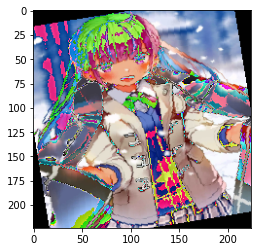

In [ ]:
# train_loader = DataLoader(data_train, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_train, batch_size=32, shuffle=True)
data_loader = DataLoader(data, batch_size=32, shuffle=True)
# 画像を一枚表示する
imgs, labels = iter(data_loader).next()
print(imgs[0].shape)
pic = transforms.ToPILImage(mode='RGB')(imgs[0])
plt.imshow(pic)
print("label is ", labels[0].numpy())

In [ ]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
  param.requires_grad = False

resnet_infeature_count = model.fc.in_features
model.fc = nn.Linear(resnet_infeature_count, 5)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
EPOCHS = 40
losses = []
accs = []

for epoch in range(EPOCHS):
  curloss = 0.0
  curacc = 0.0
  model.train()
  for imgs, labels in data_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    output = model(imgs)
    loss = loss_fun(output, labels)
    curloss += loss.item()
    pred = torch.argmax(output, dim=1)
    curacc += torch.mean(pred.eq(labels).float())
    loss.backward()
    optimizer.step()
  curloss /= len(data_loader)
  curacc /= len(data_loader)
  losses.append(curloss)
  accs.append(curacc)
  print(f"epoch: { epoch }, loss: { curloss }, acc: { curacc }")

epoch: 0, loss: 0.27334598248655145, acc: 0.9517045617103577
epoch: 1, loss: 0.26906741613691504, acc: 0.9573863744735718
epoch: 2, loss: 0.26648835837841034, acc: 0.9602273106575012
epoch: 3, loss: 0.2378568879582665, acc: 0.9630681872367859
epoch: 4, loss: 0.23263152079148727, acc: 0.9602273106575012
epoch: 5, loss: 0.2285241809758273, acc: 0.9630681872367859
epoch: 6, loss: 0.21741090579466385, acc: 0.9602273106575012
epoch: 7, loss: 0.21449357271194458, acc: 0.9630681872367859
epoch: 8, loss: 0.21713235026056116, acc: 0.9602273106575012
epoch: 9, loss: 0.18030175363475626, acc: 0.9857954978942871
epoch: 10, loss: 0.17667048830877652, acc: 0.9772727489471436
epoch: 11, loss: 0.19620204107327896, acc: 0.96875
epoch: 12, loss: 0.18314765732396732, acc: 0.96875
epoch: 13, loss: 0.19760754772207953, acc: 0.9630681872367859
epoch: 14, loss: 0.16734126955270767, acc: 0.9772727489471436
epoch: 15, loss: 0.17899706959724426, acc: 0.9857954978942871
epoch: 16, loss: 0.18346365202556958, acc:

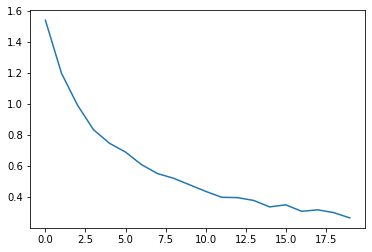

In [ ]:
plt.plot(losses)

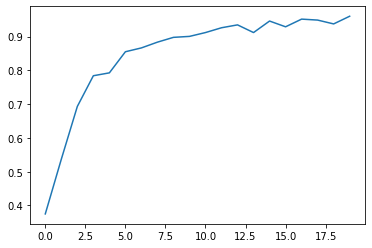

In [ ]:
plt.plot(accs)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/colab_storage/chara_classifier_model.pth')
# torch.save(model.to('cpu').state_dict(), '/content/drive/MyDrive/colab_storage/chara_classifier_model4cpu.pth')

In [ ]:
val_transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize((0.5, ), (0.5, ))
])

In [ ]:
def read_img(img: str, transform: transforms):
  img = Image.open(img)
  return transform(img)

In [ ]:
from google.colab import  files
files.upload()

In [ ]:
img = read_img('./kawayo3.jpg', val_transform)
type(img)

torch.Tensor

In [ ]:
model.eval()
test = img.unsqueeze(0)
print(test.shape)
output = model(test.to(device))
# outputがラベル1の予測値、ラベル2の予測値...となっているのでargmaxすることで予測結果が出る
print(output.argmax())

torch.Size([1, 3, 224, 224])
tensor(1, device='cuda:0')


In [ ]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
  param.requires_grad = False

resnet_infeature_count = model.fc.in_features
model.fc = nn.Linear(resnet_infeature_count, 5)

model.load_state_dict(torch.load('/content/drive/MyDrive/colab_storage/chara_classifier_model.pth'))
torch.save(model.to('cpu').state_dict(), '/content/drive/MyDrive/colab_storage/chara_classifier_model4cpu.pth')